<table align="left">
  <td>
    <a href="https://colab.research.google.com/https://github.com/hassan-ademola/Hamoye_capstone_project_smote/tree/main/Final%20models/deep_learning/efficientnetb7_0.999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Problem Statement
This project aims to classify scraped images of wildlife animals into four classes; namely, Buffalo, Elephant, Rhino, and Zebra.

In [1]:
# necessary imports
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np


# for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# define file paths
! git clone https://github.com/hassan-ademola/Hamoye_capstone_project_smote.git
BASE = 'Hamoye_capstone_project_smote/Data'
train_path = f'{BASE}/train/'
val_path = f'{BASE}/val/'
test_path = f'{BASE}/test/'

fatal: destination path 'Hamoye_capstone_project_smote' already exists and is not an empty directory.


In [3]:
import os
import pandas as pd

df = pd.DataFrame()

for set_ in ['train','test','val']:
    for class_ in ['Buffalo','Elephant','Rhino','Zebra']:
        fnames = os.listdir(f'{BASE}/{set_}/{class_}')
        df = df.append(pd.DataFrame({'fname':fnames,'class':class_,'set':set_}))

Older versions of matplotlib do not have the **bar_label** method. We'll upgrade the package

In [4]:
! pip install --upgrade matplotlib

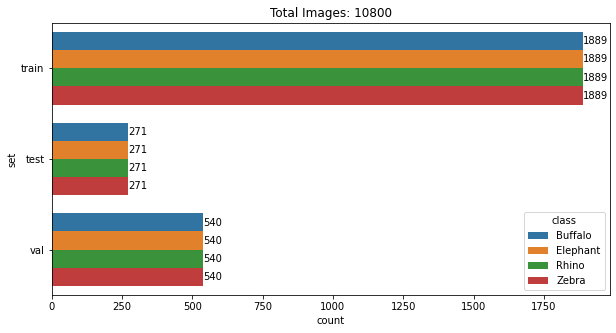

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = sns.countplot(y='set',hue='class',data=df)
for container in ax.containers:
    ax.bar_label(container)
plt.title(f'Total Images: {len(df)}');

Each set contains the four animal classes in equal proportion.

Let's generate batches of the images for training and evaluation.

In [6]:
# generate train and evaluation sets from directories
train_ds = image_dataset_from_directory(train_path,label_mode='categorical',
                                        batch_size=32, image_size=(528, 528))
val_ds = image_dataset_from_directory(val_path,label_mode='categorical',
                                      batch_size=32, image_size=(528, 528))
test_ds = image_dataset_from_directory(test_path,label_mode='categorical',
                                       shuffle=False, batch_size=32, 
                                       image_size=(528, 528))

Found 7556 files belonging to 4 classes.
Found 2160 files belonging to 4 classes.
Found 1084 files belonging to 4 classes.


Each batch in the generated sets contains at most 32 tensors representing 32 unique images.

Let's visualize images from the train set

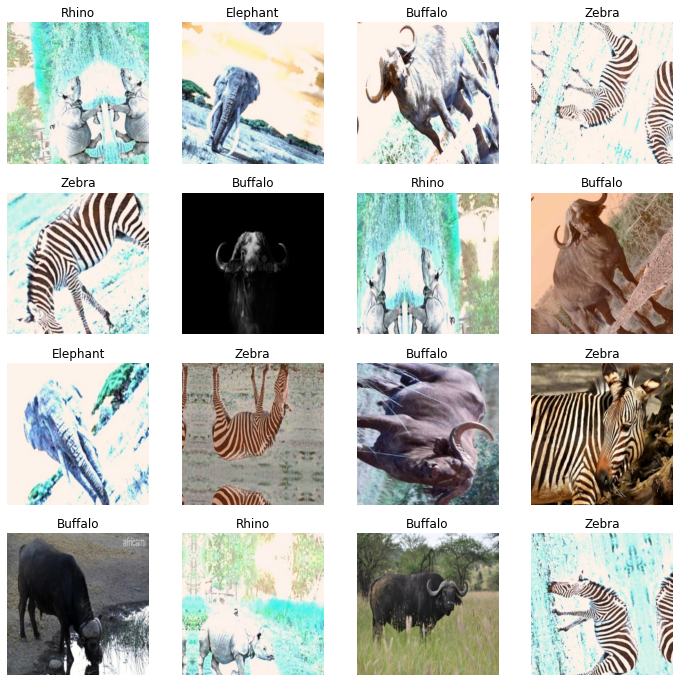

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.array(labels[i]).argmax()])
        plt.axis("off")

Let's make a prediction on an image using the **efficientnetb6** pretrained model

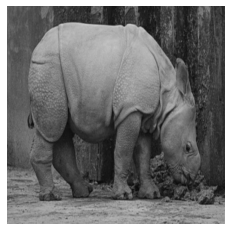

In [8]:
# visualize the image
for images, label in train_ds.take(1):
    first_image = images[0]
plt.imshow(first_image.numpy().astype("uint8"))
plt.axis('off');

In [9]:
# make predictions using a pretrained model
from keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.preprocessing import image

x = image.img_to_array(first_image)
x = np.expand_dims(x, axis=0)

base_model = EfficientNetB6(weights='imagenet')
pred = base_model.predict(x)
print('Predicted:', decode_predictions(pred))

49152/35363 [=========================================] - 0s 0us/step
Predicted: [[('n02398521', 'hippopotamus', 0.7757862), ('n01704323', 'triceratops', 0.040475704), ('n02504013', 'Indian_elephant', 0.008777515), ('n02504458', 'African_elephant', 0.0072573023), ('n02454379', 'armadillo', 0.004746104)]]


The pretrained model is about 78% sure that the image is a hippopotamus

# Model Building and Evaluation

We can now train an EfficientNetB6 model to suit our task. 

The **include_top** hyperparameter specifies whether to include the fully connected layer(s) or not. We'll drop this layer since we only need the extraction layer. 

We'll then add a **GlobalAveragePooling2D** layer to extract features for the prediction layer. 

Since we only have 4 exclusive classes, we'll finally add an output layer with 4 classes using the softmax activation function

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = EfficientNetB6(weights='imagenet', include_top=False,
                            input_shape=(528,528,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

165249024/165234480 [==============================] - 2s 0us/step


By setting **base_model.trainable=False**, only the weights of the custom layers would be adjusted during training

The ModelCheckpoint callback ensures that we don't lose our model even when training stops abruptly. By specifying **save_weights_only**, only the best performing version of the model is saved.

In [11]:
# create callback to use during training
checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.h5',save_best_only=True,
                                                    save_weights_only=True)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_ds,epochs=10,validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/10
237/237 [==============================] - 1104s 5s/step - loss: 0.1490 - accuracy: 0.9708 - val_loss: 0.0328 - val_accuracy: 0.9954
Epoch 2/10
237/237 [==============================] - 1060s 4s/step - loss: 0.0316 - accuracy: 0.9934 - val_loss: 0.0198 - val_accuracy: 0.9958
Epoch 3/10
237/237 [==============================] - 1058s 4s/step - loss: 0.0205 - accuracy: 0.9951 - val_loss: 0.0158 - val_accuracy: 0.9958
Epoch 4/10
237/237 [==============================] - 1061s 4s/step - loss: 0.0148 - accuracy: 0.9974 - val_loss: 0.0136 - val_accuracy: 0.9954
Epoch 5/10
237/237 [==============================] - 1061s 4s/step - loss: 0.0121 - accuracy: 0.9972 - val_loss: 0.0122 - val_accuracy: 0.9958
Epoch 6/10
237/237 [==============================] - 1061s 4s/step - loss: 0.0108 - accuracy: 0.9979 - val_loss: 0.0120 - val_accuracy: 0.9958
Epoch 7/10
237/237 [==============================] - 1062s 4s/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.0112 - val_accuracy:

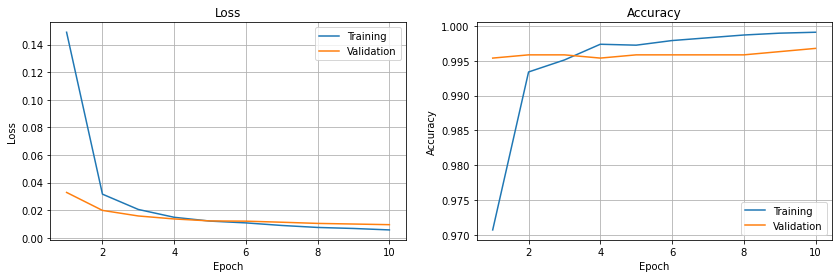

In [12]:
# save results
results = history.history

# plot results
import matplotlib.pyplot as plt
n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The plots are close so there is little to no sign of overfitting

In [13]:
# load the best performing weights
model.load_weights('weights.h5')

In [14]:
# evaluate model on test set
predictions = model.evaluate(test_ds)

34/34 [==============================] - 124s 4s/step - loss: 0.0052 - accuracy: 1.0000


In [15]:
# make predictions on the test data
predictions = model.predict(test_ds)
predictions

array([[9.9901712e-01, 7.2388117e-05, 7.9839164e-04, 1.1201100e-04],
       [9.9975055e-01, 5.4035871e-05, 1.5665633e-04, 3.8828337e-05],
       [9.9617213e-01, 2.1951846e-05, 3.7568777e-03, 4.9090737e-05],
       ...,
       [2.8896309e-06, 8.7399349e-05, 2.8214763e-06, 9.9990690e-01],
       [8.4766079e-06, 7.1584538e-05, 6.2333943e-06, 9.9991369e-01],
       [3.5810024e-07, 3.6848251e-06, 5.6924563e-07, 9.9999535e-01]],
      dtype=float32)

The model outputs probabilities. To get the predicted class, we'll choose the class with the highest probability. Numpy's **argmax** method is an easy way to do this.

In [16]:
# save the index of the highest probability
predictions = predictions.argmax(axis=1)
predictions

array([0, 0, 0, ..., 3, 3, 3])

As expected, the classes are ordered from 0 to 3. This is because we did not shuffle out test set during generation. 

Now, we'll get the actual classes and compare with our model's predictions

In [17]:
# get the actual classes
test_images = list(test_ds.unbatch().as_numpy_iterator())
y_true = np.array([i[1] for i in test_images])
y_true = y_true.argmax(axis=1)
y_true

array([0, 0, 0, ..., 3, 3, 3])

In [18]:
# calculate f1_score
from sklearn.metrics import classification_report
print(classification_report(y_true,predictions,target_names=test_ds.class_names))

              precision    recall  f1-score   support

     Buffalo       1.00      1.00      1.00       271
    Elephant       1.00      1.00      1.00       271
       Rhino       1.00      1.00      1.00       271
       Zebra       1.00      1.00      1.00       271

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084



In [19]:
# get the f1 score
from sklearn.metrics import f1_score
f1_score(y_true,predictions,average='macro')

1.0

The model performance looks very promising on the unseen test set

In [20]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,predictions)

array([[271,   0,   0,   0],
       [  0, 271,   0,   0],
       [  0,   0, 271,   0],
       [  0,   0,   0, 271]])

There are no misclassified images

# Prediction Pipeline

We can make a pipepile to convert an image object into an array and make predictions

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class Preprocessor(BaseEstimator, TransformerMixin):
    def fit(self,img_object):
        return self
    
    def transform(self,img_object):
        img_array = image.img_to_array(img_object)
        expanded = (np.expand_dims(img_array,axis=0))
        return expanded

class Predictor(BaseEstimator, TransformerMixin):
    def fit(self,img_array):
        return self
    
    def predict(self,img_array):
        probabilities = model.predict(img_array)
        predicted_class = test_ds.class_names[probabilities.argmax()]
        return predicted_class

full_pipeline = Pipeline([('preprocessor',Preprocessor()),
                         ('predictor',Predictor())])

Let's make predictions with our pipeline on some of the test images

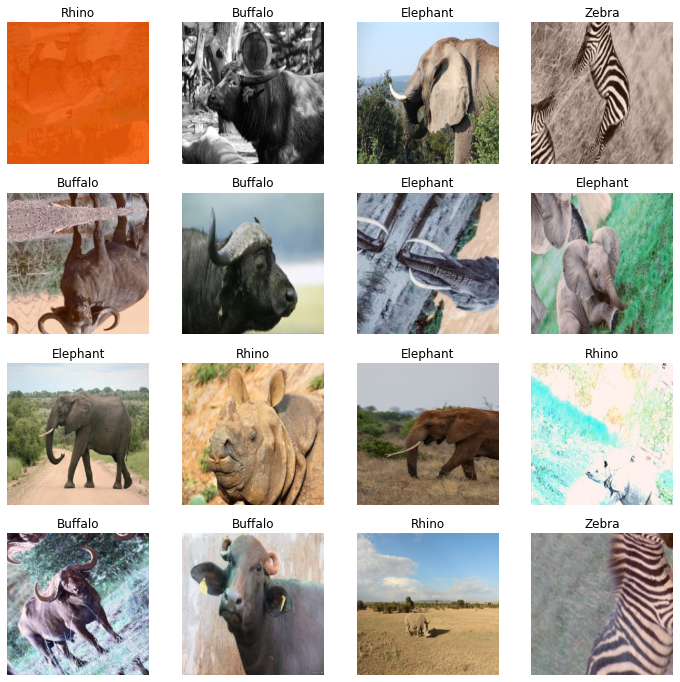

In [27]:
# select the paths for 16 random images
np.random.seed(SEED)
selected = np.random.choice(test_ds.file_paths,16,replace=False)

plt.figure(figsize=(12, 12))
for i,path in enumerate(selected):
    ax = plt.subplot(4, 4, i + 1)
    img = image.load_img(path,target_size=(528,528))
    prediction = full_pipeline.predict(img)
    plt.imshow(img)
    plt.title(prediction)
    plt.axis("off")

In [29]:
# uncomment the line below to save the model
#model.save('model.h5')